In [ ]:
!pip install -U transformers


In [ ]:
!pip install datasets
!pip install soundfile
!pip install librosa

In [ ]:
!pip install git+https://github.com/huggingface/transformers

In [ ]:
!pip install speechbrain accelerate

In [ ]:
!apt-get install git-lfs
!git lfs install

In [ ]:
!pip install wandb --upgrade

#### SpeechT5

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [ ]:
inputs = processor(text="Don't count the days, make the days count", return_tensors="pt")

In [ ]:
# load speaker embedding
from datasets import load_dataset
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")


In [ ]:
import torch
speaker_embeddings = torch.tensor(embeddings_dataset[6306]["xvector"]).unsqueeze(0) # change which voice here

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

In [ ]:
# load vocoder to generate audio from log mel spectrogram
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [ ]:
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [ ]:
import IPython
IPython.display.Audio(speech, rate=16_000)

#### Massive Multilingual Speech (MMS)

In [ ]:
#not merged yet so install from branch
!pip install -U git+https://github.com/hollance/transformers.git@vits

In [ ]:
from transformers import VitsModel

## Fine-tuning SpeechT5


### Housekeeping

In [1]:
from huggingface_hub import notebook_login

notebook_login()

### The dataset

In [2]:
from datasets import load_dataset, Audio

dataset = load_dataset("google/fleurs", "af_za", split="train+validation")

Reusing dataset fleurs (/root/.cache/huggingface/datasets/google___fleurs/af_za/2.0.0/af82dbec419a815084fa63ebd5d5a9f24a6e9acdf9887b9e3b8c6bbd64e0b7ac)


In [3]:
len(dataset)

1230

In [4]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

### Preprocessing the data

In [5]:
from transformers import SpeechT5Processor
checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

#### Text cleanup for SpeechT5 tokenization

In [6]:
tokenizer = processor.tokenizer

In [7]:
dataset[0]

{'id': 766,
 'num_samples': 72960,
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/07fd8de8281f096d64b7bc81fee35a47a40456aa276a1d6cefd6df6884f73065/10010386886416577453.wav',
 'audio': {'path': 'train/10010386886416577453.wav',
  'array': array([0.        , 0.        , 0.        , ..., 0.00410163, 0.0040049 ,
         0.00438273]),
  'sampling_rate': 16000},
 'transcription': "families met kinders is nie 'n algemene verskynsel nie maar party koshuise laat hulle in privaat kamers toe",
 'raw_transcription': 'Families met kinders is nie ‘n algemene verskynsel nie, maar party koshuise laat hulle in privaat kamers toe.',
 'gender': 1,
 'lang_id': 0,
 'language': 'Afrikaans',
 'lang_group_id': 3}

In [8]:
def extract_all_chars(batch):
    all_text = " ".join(batch["transcription"])
    vocab = list(set(all_text))
    return {"vocab":[vocab], "all_text": [all_text]}

In [9]:
vocabs = dataset.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=dataset.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

In [11]:
tokenizer_vocab

{'!',
 '"',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '</s>',
 '<ctc_blank>',
 '<mask>',
 '<pad>',
 '<s>',
 '<unk>',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '}',
 'æ',
 'é',
 'ê',
 'œ',
 '̄',
 '—',
 '▁'}

In [12]:
# identify all special characters that tokenizer does not contain
dataset_vocab - tokenizer_vocab

{' ',
 '$',
 '%',
 '&',
 '+',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '£',
 '¥',
 '°',
 '²',
 'á',
 'ç',
 'ë',
 'í',
 'ï',
 'ó',
 'ö',
 'ú',
 'ü',
 'ł',
 'ń',
 'ͦ',
 'ϊ',
 '–',
 '‘',
 '’',
 '”'}

In [13]:
replacements= [
    ('á', 'a'),
    ('ç', 'c'),
    ('è', 'e'),
    ('ë', 'e'),
    ('í', 'i'),
    ('ï', 'i'),
    ('ó', 'o'), 
    ('ö', 'o'),
    ('ú', 'u'),
    ('ü', 'u'),
    ('ł', 'l'),
    ('ń', 'n'),
    ('ϊ', 'i'),
]

In [14]:
# replace special characters
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["transcription"] = inputs["transcription"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)
    

Loading cached processed dataset at /root/.cache/huggingface/datasets/google___fleurs/af_za/2.0.0/af82dbec419a815084fa63ebd5d5a9f24a6e9acdf9887b9e3b8c6bbd64e0b7ac/cache-87feffed387ca308.arrow


In [15]:
from collections import defaultdict
speaker_counts = defaultdict(int)
for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1
    

KeyError: "Column speaker_id not in the dataset. Current columns in the dataset: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']"

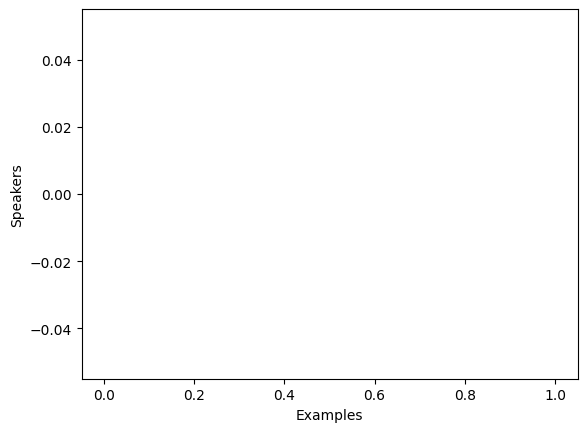

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [17]:
# balance dataset by limiting speakers to middle
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400
dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

ValueError: Input column speaker_id not in the dataset. Current columns in the dataset: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']

In [ ]:
len(set(dataset["speaker_id"]))

In [ ]:
len(dataset)

#### Speaker embeddings

In [18]:
# needed to differentiate between multiple speakers
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"
device = "cuda"
speaker_model = EncoderClassifier.from_hparams(source=spk_model_name, run_opts={"device":device}, savedir=os.path.join("/tmp", spk_model_name))

In [19]:
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

#### Processing the dataset

In [20]:
def prepare_dataset(example):
    audio = example["audio"]
    example = processor(text=example["transcription"], audio_target=audio["array"], sampling_rate=audio["sampling_rate"], return_attention_mask=False)
    # strip off batch dimension
    example["labels"] = example["labels"][0]
    
    #use SpeechBrain to get x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])
    return example

In [21]:
# test with one example
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [22]:
# check embeddings shape
processed_example["speaker_embeddings"].shape

(512,)

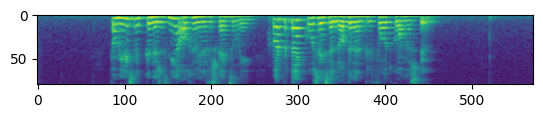

In [23]:
# check labels is log-mel spectrogram with 80 bins
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [24]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)
dataset

  0%|          | 0/1230 [00:00<?, ?ex/s]

Dataset({
    features: ['input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 1230
})

In [25]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 400
dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

  0%|          | 0/2 [00:00<?, ?ba/s]

1230

In [26]:
dataset = dataset.train_test_split(test_size=0.1)

#### Data collator

In [27]:
# to combine multiple examples into a batch, you need to define a custom data collator. 
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [28]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

### Train the model

In [29]:
from transformers import SpeechT5ForTextToSpeech
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [30]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [31]:
import wandb
wandb.login()

wandb: Currently logged in as: ptah23. Use `wandb login --relogin` to force relogin


True

In [32]:
wandb.init(project="huggingface-audio-course-unit6-handson", resume=True)

In [36]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_fleurs_af",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=4,
    save_steps=100,
    eval_steps=100,
    logging_steps=25,
    report_to=["wandb"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [37]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/notebooks/speecht5_finetuned_fleurs_af is already a clone of https://huggingface.co/ptah23/speecht5_finetuned_fleurs_af. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
trainer.train()
#trainer.train(resume_from_checkpoint=True)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.628600,0.541888
200,0.560500,0.496210
300,0.509500,0.459693
400,0.478700,0.422572
500,0.444200,0.406666
600,0.430800,0.395655
700,0.431700,0.393401
800,0.419200,0.387783
900,0.417700,0.383551
1000,0.405800,0.383442


In [ ]:
trainer.push_to_hub()

### Inference

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained("ptah23/speecht5_finetuned_fleurs_af")

In [ ]:
example = dataset["test"][206]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [ ]:
text = "hallo almal, ek praat afrikaans, welkom aan elke een van julle!"
inputs = processor(text=text, return_tensors="pt")

In [ ]:
# instantiate vocoder and generate
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [ ]:
import IPython
IPython.display.Audio(speech.numpy(), rate=16000)